In [1]:
# Додати лайн, бар, донат, пай графіки туди, куди має сенс у ваших наборах даних.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from matplotlib.patches import Patch, Wedge
import warnings
import textwrap


warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
plt.style.use('seaborn-v0_8-notebook')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

diabetes_data = pd.read_csv('../data/diabetes_enriched.csv')

In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

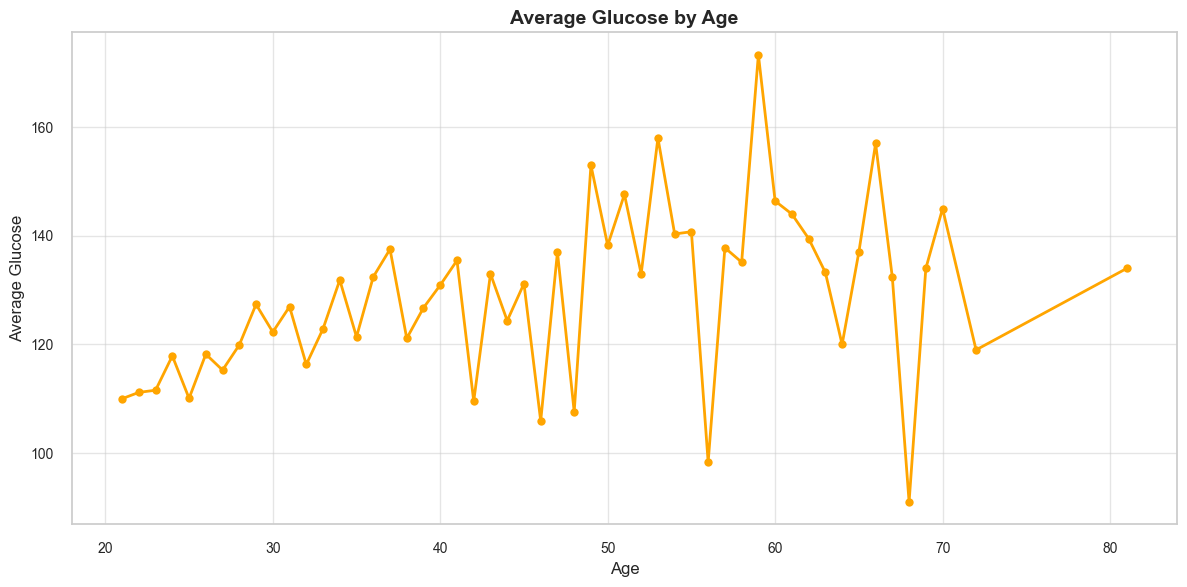

In [3]:
# Лайн
# Маємо не багато безперервних метрик, та не маємо явних прогресій у часі.
# Проте все ще можемо глянути, наприклад, як змінюється рівень глюкози з віком.

avg_glucose = (
    diabetes_data.groupby("Age")["Glucose"]
      .mean()
      .sort_index()
)
fig, ax = plt.subplots()

ax.plot(avg_glucose.index, avg_glucose.values, color='orange', linewidth=2, marker='o', markersize=6)
ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Average Glucose', fontsize=12)
ax.set_title('Average Glucose by Age', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

# Видно що медіана Глюкози зростає з віком, проте спростерігаємо спад після 60.
# Моя теорія: люди з поганим рівнем глюкози довго не живуть.

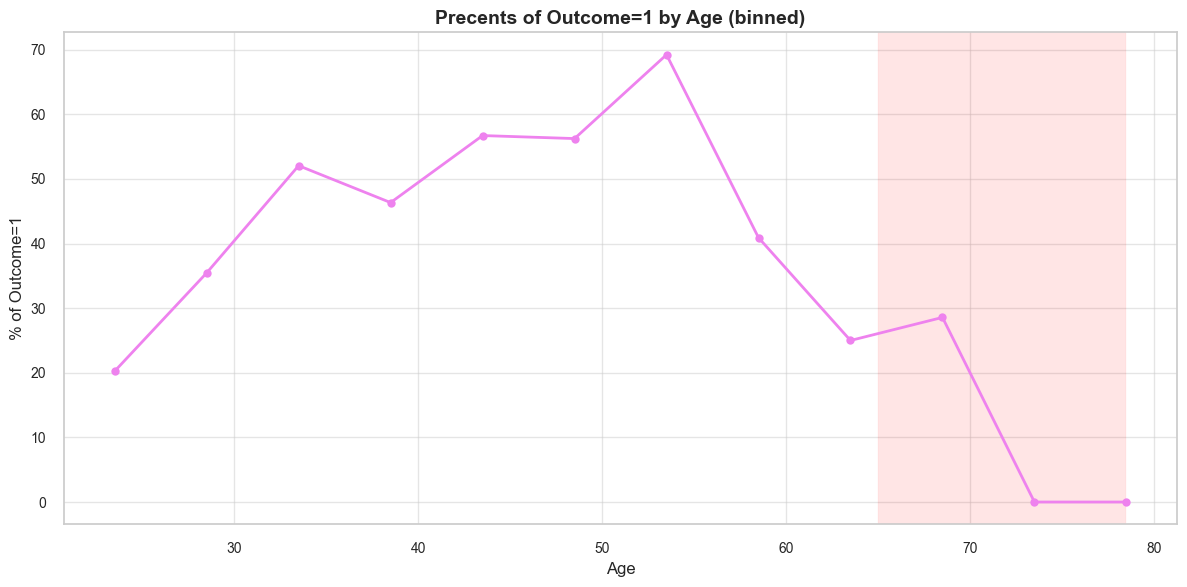

In [4]:
# Перевіримо мою теорію з попереднього блоку, глянемо на діабетиків в різного віку.
bin_size = 5
age_min = diabetes_data["Age"].min()
age_max = diabetes_data["Age"].max()
bins = pd.interval_range(start=age_min, end=age_max + bin_size, freq=bin_size)

diabetes_data["Age_bin"] = pd.cut(diabetes_data["Age"], bins=bins, include_lowest=True)

rate_pct = (
    diabetes_data.groupby("Age_bin")["Outcome"]
    .mean()
    .mul(100)
    .sort_index()
)

x = [interval.mid for interval in rate_pct.index]
y = rate_pct.values

fig, ax = plt.subplots()

ax.plot(x, y, color='violet', linewidth=2, marker='o', markersize=6)

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('% of Outcome=1', fontsize=12)
ax.set_title('Precents of Outcome=1 by Age (binned)', fontsize=14, fontweight='bold')

ax.axvspan(65, 78.5, alpha=0.1, color='red', label='')

ax.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()

# Бачимо що люди з діабетом не проходять поріг 70 років, принаймі в рамках цього датасету.
# Що підтверджує мою теорію стосовно ріня глюкози з попереднього блоку.

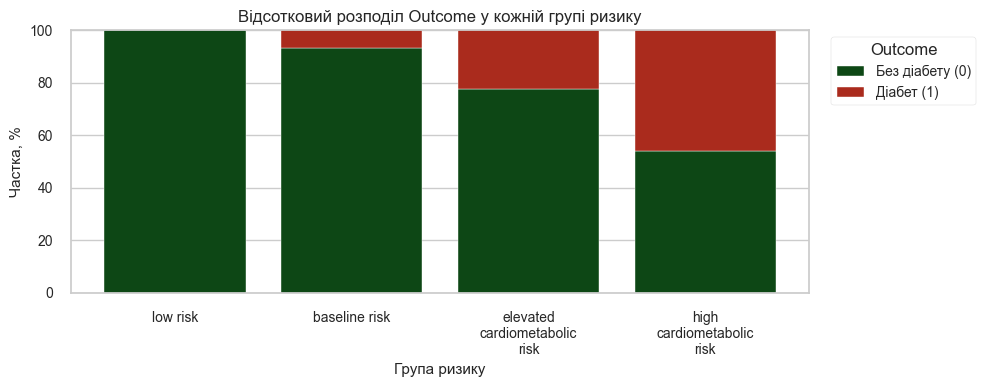

In [5]:
group_col = "risk_note"

pct = (
    diabetes_data
    .pivot_table(index=group_col, columns="Outcome", aggfunc="size", fill_value=0)
    .pipe(lambda x: x.div(x.sum(axis=1), axis=0) * 100)
    .reset_index()
)
long = pct.melt(id_vars=group_col, var_name="Outcome", value_name="pct")

if "severity_rank" in diabetes_data.columns and group_col == "risk_note":
    order = (
        diabetes_data[[group_col, "severity_rank"]]
        .drop_duplicates()
        .sort_values("severity_rank")[group_col]
        .tolist()
    )
else:
    order = sorted(diabetes_data[group_col].dropna().unique())

fig, ax = plt.subplots(figsize=(10, 4))


bottom = {k: 0 for k in order}
palette = {0: "#0D4715", 1: "#AA2B1D"}

for outcome in [0, 1]:
    part = long[long["Outcome"] == outcome].set_index(group_col).reindex(order)["pct"].fillna(0)
    ax.bar(order, part.values, bottom=[bottom[k] for k in order], color=palette[outcome], label=f"Outcome={outcome}")
    for k, v in zip(order, part.values):
        bottom[k] += v

ax.set_title("Відсотковий розподіл Outcome у кожній групі ризику")
ax.set_xlabel("Група ризику")
ax.set_ylabel("Частка, %")
ax.set_ylim(0, 100)
ax.legend(title="Outcome", labels=["Без діабету (0)", "Діабет (1)"], bbox_to_anchor=(1.02, 1), loc="upper left")
ax.set_xticklabels(
    ["\n".join(textwrap.wrap(lbl, width=18)) for lbl in order],
    rotation=0,
    ha="center",
)
plt.tight_layout()
plt.show()
# Можемо візуально впевнитися що групи з більшим ризиком мають фактично більший відсоток людей з діабетом.

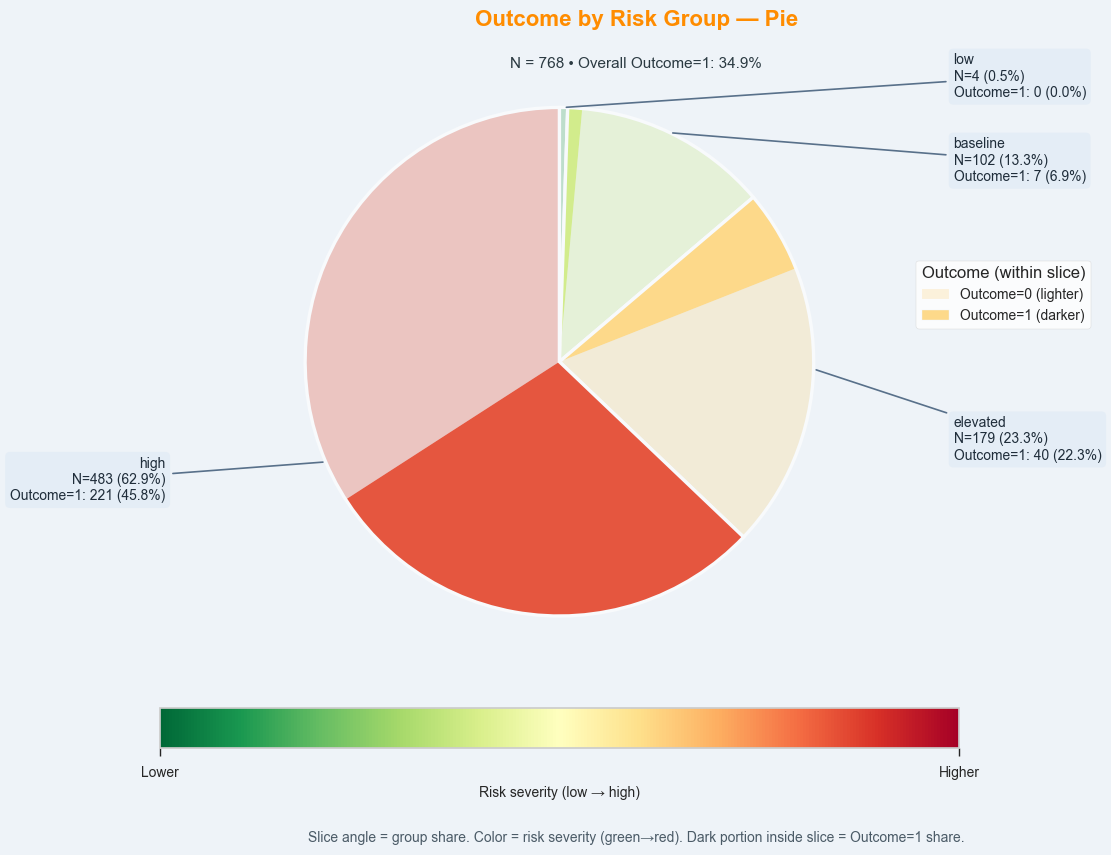

In [26]:
# Тут у мене виникла ідея зобразити, по суті, попередні дані, але у вигляді pie чарту.
# Як зʼясувалося походу, у моїй голові воно було простіше, але (не без підказок ЛЛМ) вимучав візуал котрий хотів.

group_col = globals().get("group_col", "risk_note")
df = diabetes_data.dropna(subset=[group_col, "Outcome"]).copy()
df["Outcome"] = df["Outcome"].astype(int)

if "severity_rank" in df.columns and group_col == "risk_note":
    order = (
        df[[group_col, "severity_rank"]]
        .drop_duplicates()
        .sort_values("severity_rank")[group_col]
        .tolist()
    )
else:
    order = sorted(df[group_col].unique())

counts = (
    df.pivot_table(index=group_col, columns="Outcome", aggfunc="size", fill_value=0)
    .reindex(order)
    .fillna(0)
    .astype(int)
)
for col in (0, 1):
    if col not in counts.columns:
        counts[col] = 0
counts = counts[[0, 1]]

group_total = counts.sum(axis=1)
group_share = (group_total / max(1, len(df)) * 100).fillna(0)
group_rate = (counts[1] / group_total * 100).fillna(0)

cmap = mpl.colormaps.get_cmap("RdYlGn_r")
den = max(1, len(order) - 1)
base_colors = [cmap(0.15 + 0.70 * (i / den)) for i in range(len(order))]

bg = "#EEF3F8"
box_bg = "#E4EDF6"
edge = "#58708A"
wedge_sep = "#F8FAFC"
wedge_sep_lw = 2.4

# Будемо візуально виділяти частину сектору де ризок був реалізований за допомогою прозорості.
alpha_light = 0.28  # Outcome=0 area
alpha_dark = 0.95   # Outcome=1 area

fig, ax = plt.subplots(figsize=(14, 9), subplot_kw=dict(aspect="equal"))
fig.patch.set_facecolor(bg)
ax.set_facecolor(bg)

startangle = 90
clockwise = True
radius = 1.0

total_n = float(group_total.sum()) if float(group_total.sum()) > 0 else 1.0
cur = startangle

group_mid_angles = {}

for grp, base_col in zip(order, base_colors):
    n = float(group_total.loc[grp])
    span = 360.0 * (n / total_n)

    theta2 = cur
    theta1 = cur - span if clockwise else cur + span
    cur = theta1

    n1 = float(counts.loc[grp, 1])
    frac1 = (n1 / n) if n > 0 else 0.0
    frac1 = float(max(0.0, min(1.0, frac1)))

    dark_span = span * frac1
    light_span = span - dark_span

    dark_theta1 = theta2 - dark_span if clockwise else theta2
    dark_theta2 = theta2 if clockwise else theta2 + dark_span

    light_theta1 = theta1
    light_theta2 = dark_theta1 if clockwise else dark_theta2

    # Outcome=0
    if light_span > 0:
        ax.add_patch(
            Wedge(
                (0, 0),
                radius,
                theta1=light_theta1,
                theta2=light_theta2,
                facecolor=base_col,
                alpha=alpha_light,
                edgecolor="none",
                linewidth=0,
            )
        )

    # Outcome=1
    if dark_span > 0:
        ax.add_patch(
            Wedge(
                (0, 0),
                radius,
                theta1=dark_theta1,
                theta2=dark_theta2,
                facecolor=base_col,
                alpha=alpha_dark,
                edgecolor="none",
                linewidth=0,
            )
        )

    ax.add_patch(
        Wedge(
            (0, 0),
            radius,
            theta1=theta1,
            theta2=theta2,
            facecolor="none",
            edgecolor=wedge_sep,
            linewidth=wedge_sep_lw,
        )
    )

    group_mid_angles[grp] = (theta1 + theta2) / 2.0

ax.set_autoscale_on(False)
ax.set_xlim(-1.25, 1.25)
ax.set_ylim(-1.10, 1.10)

overall_rate = df["Outcome"].mean() * 100
fig.suptitle("Outcome by Risk Group — Pie", fontsize=16, fontweight="bold", ha="center", color="darkorange")
fig.text(
    0.5,
    0.92,
    f"N = {len(df):,} • Overall Outcome=1: {overall_rate:.1f}%",
    ha="center",
    va="center",
    fontsize=11,
    color="#2B3A42",
)

items = []
for grp in order:
    ang = group_mid_angles.get(grp, 0.0)
    ang_rad = np.deg2rad(ang)

    x = np.cos(ang_rad)
    y = np.sin(ang_rad)

    n = int(group_total.loc[grp])
    share = float(group_share.loc[grp])
    n1 = int(counts.loc[grp, 1])
    pct1 = float(group_rate.loc[grp])

    # Урізаємо групу до одного слова, логічно б то було зробити в очистці, тож будемо знати на майбутнє.
    grp_label = grp.split()[0]
    text = "\n".join([
        grp_label,
        f"N={n:,} ({share:.1f}%)",
        f"Outcome=1: {n1:,} ({pct1:.1f}%)",
    ])

    side = 1 if x >= 0 else -1
    items.append({"x": x, "y": y, "side": side, "text": text})


def spread_y(sorted_items, min_dy=0.28, y_min=-0.95, y_max=0.95):
    if not sorted_items:
        return
    ys = [it["y"] for it in sorted_items]
    for i in range(1, len(ys)):
        ys[i] = max(ys[i], ys[i - 1] + min_dy)
    for i in range(len(ys) - 2, -1, -1):
        ys[i] = min(ys[i], ys[i + 1] - min_dy)
    if ys[0] < y_min:
        shift = y_min - ys[0]
        ys = [y + shift for y in ys]
    if ys[-1] > y_max:
        shift = y_max - ys[-1]
        ys = [y + shift for y in ys]
    for it, y in zip(sorted_items, ys):
        it["y_adj"] = max(y_min, min(y_max, y))


right = sorted([it for it in items if it["side"] == 1], key=lambda d: d["y"])
left = sorted([it for it in items if it["side"] == -1], key=lambda d: d["y"])
spread_y(right)
spread_y(left)

label_r = 1.55
for it in right + left:
    x_txt = it["side"] * label_r
    y_txt = it.get("y_adj", it["y"]) * 1.18
    ha = "left" if it["side"] == 1 else "right"

    ax.annotate(
        it["text"],
        xy=(it["x"], it["y"]),
        xytext=(x_txt, y_txt),
        ha=ha,
        va="center",
        fontsize=10,
        color="#1F2D3A",
        bbox=dict(boxstyle="round,pad=0.35", fc=box_bg, ec="none", alpha=0.95),
        arrowprops=dict(arrowstyle="-", color=edge, lw=1.2),
        annotation_clip=False,
    )

example = base_colors[len(base_colors) // 2]
ax.legend(
    handles=[
        Patch(facecolor=example, alpha=alpha_light, edgecolor=bg, label="Outcome=0 (lighter)"),
        Patch(facecolor=example, alpha=alpha_dark, edgecolor=bg, label="Outcome=1 (darker)"),
    ],
    title="Outcome (within slice)",
    bbox_to_anchor=(1.05, 0.62),
    loc="center left",
)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=den))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.06, pad=0.10)
cbar.set_label("Risk severity (low → high)", fontsize=10)
cbar.set_ticks([0, den])
cbar.set_ticklabels(["Lower", "Higher"])

fig.text(
    0.5,
    0.06,
    "Slice angle = group share. Color = risk severity (green→red). Dark portion inside slice = Outcome=1 share.",
    ha="center",
    va="center",
    fontsize=10,
    color="#4B5B67",
)

ax.set_axis_off()
fig.subplots_adjust(left=0.05, right=0.84, top=0.90, bottom=0.16)
plt.show()

# Note: Темний фон IDE може зробити візуалізацію трохи контрінтуітивною.
# Загалом, як і на попередньому чарті, можемо бачити частину групи яка має діабет.
# Проте пай чарт дозволяє також показати частину кожної групи від загального числа, що досить зручно та інформативно.
